# GRAPPA Student Seminar 2019: Sterile Neutrinos group

## Week 1 - Script

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root
from scipy.special import zeta
from astropy import constants as C
from astropy import units
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt

We will be working in mass units, so define some constants in $\mathrm{GeV}$ (that's not even a mass unit, btw...):

In [2]:
Mp = (np.sqrt(C.hbar*C.c/(8*np.pi*C.G)) * C.c**2).to(units.GeV)
T0 = (C.k_B * cosmo.Tcmb0).to(units.GeV)
rho0 = (cosmo.critical_density0 * C.hbar**3 * C.c**5).to(units.GeV**4)

Define the grid of masses and cross-sections that we will be calculating the abundance for. These are logarithmically spaced.

In [3]:
m_edges = np.linspace(-12, 3, 201) 
sigma_edges = np.linspace(-12, -6, 201) 
m = np.power(10, 0.5*(m_edges[1:]+m_edges[:-1])) * units.GeV
sigma = np.power(10, 0.5*(sigma_edges[1:]+sigma_edges[:-1])) * units.GeV**(-2)
g = 1

def plot(Odm):
    plt.pcolormesh(m_edges, sigma_edges, np.log10(Odm))
    plt.xlabel('$m$')
    plt.ylabel(r'$\left\langle{\sigma v}\right\rangle_{fo}, \mathrm{GeV}^{-2}$')
    plt.xticks((-12, -9, -6, -3, 0, 3), (r'$\mathrm{meV}$', r'$\mathrm{eV}$', r'$\mathrm{keV}$', r'$\mathrm{MeV}$', r'$\mathrm{GeV}$', r'$\mathrm{TeV}$'))
    plt.colorbar()

### Part 1: Instantaneous freeze-out

#### a. Relativistic (hot) dark matter

The number density of a relativistic species is given by
$$n = \frac{\zeta(3)}{\pi^2} g T^3,$$
where $\zeta(3) \approx 1.202$ is Apéry's constant, and $g$ is its number of degrees of freedom (including a factor of $3/4$ for a fermionic species). We will combine the constants into a single number and write $n=\mathcal{N}T^3$. Because of the simple $T^3$ dependence of the number density, relativistic species redshift in the same way regardless of whether they are in thermal equilibrium ($n \propto T^3$), or not ($n \propto a^{-3} \propto T_{\gamma}^3$, with $T_\gamma$ the photon temperature), and so we can simply estimate their present number density as $n = \mathcal{N} T_0^3$. Therefore, their present-day abundance is simply
$$\Omega_{\textrm{HDM}, 0} = \frac{n m}{\rho_c} = \frac{\zeta(3)}{\pi^2} \frac{T_0^3}{\rho_c} gm.$$
Note that it does not depend on the reaction cross-section since, as mentioned, it does not matter whether the DM particles react (are in thermal equilibrium) or not. Also note that $T_0$ is *their* present temperature. In calculations, though, we will be using the CMB (photon) temperature. A difference between the two can be present if another species remained in equilibrium with the photons after the dark matter decoupled and subsequently annihilated (as in the case of $e^+/e^-$, which led to a factor $11/4$ increase in $T_\gamma^3$ post-neutrino decoupling due to the electron-positron annihilation heat).

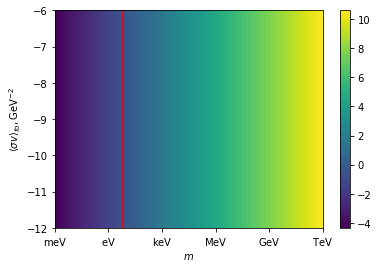

In [4]:
Ohdm0 = ((zeta(3)/np.pi**2) * (T0**3 / rho0) * g * m).to('').value
plot(np.broadcast_to(Ohdm0, np.broadcast(m[None, :], sigma[:, None]).shape))
plt.vlines(np.log10((cosmo.Odm0 * (np.pi**2 / zeta(3)) * (rho0 / T0**3) / g).to('GeV').value),
           sigma_edges[0], sigma_edges[-1], colors='r')

The red line in the above plot indicates the mass that fits the Planck 2015 result of $\Omega_{\textrm{DM}, 0} = 0.26$.

#### b. Non-relativistic (cold) dark matter

For a non-relativistic (cold: $m>T$) species, the number density derives from the classical Maxwell-Boltzmann distribution:
$$n = g \left(\frac{mT}{2\pi}\right)^{3/2} \textrm{e}^{-m/T}.$$
Here $g$ is the number of classical degrees of freedom (no additional factors for spin statistics). Equating the reaction rate that results from such a number density $\Gamma = n\sigma v$ to the Hubble parameter $H = T^2 / M_p$ at the time of decoupling (freeze-out):
$$n_{fo} \left\langle\sigma v\right\rangle_{fo} = \frac{T_{fo}^2}{M_p} \quad\implies\quad g \left(\frac{mT_{fo}}{2\pi}\right)^{3/2} \textrm{e}^{-m/T} = \frac{T_{fo}^2}{M_p \left\langle\sigma v\right\rangle_{fo}},$$
which can be rearranged and expressed in terms of the dimensionless variable $x\equiv m/T$:
$$\sqrt{x_{fo}}\textrm{e}^{-x_{fo}} = \frac{\left(2\pi\right)^{3/2}}{g} \frac{1}{M_p m \left\langle\sigma v\right\rangle_{fo}} \equiv A.$$
This transcendental equation can be solved numerically for all values $A < 1/\sqrt{2\textrm{e}}$ of the right-hand-side. In fact, there are two solutions: one smaller and one larger than $x=1/2$, corresponding to the location of the maximum of the LHS. Furthermore, we are interested only in the case of a cold particle for which $x>1$, so we further restrict the possible values to $A<1/\textrm{e}$.

Once we have $x_{fo}$, we can calculate the present-day abundance using the formula from the lecture notes
$$\Omega_{\textrm{CDM}, 0} = \frac{T_0^3}{\rho_c M_p} \frac{x_{fo}}{\left\langle\sigma v\right\rangle_{fo}}.$$

In [5]:
A = (((2*np.pi)**(3/2) / g) / (Mp * m[None, :] * sigma[:, None])).to('').value

# One-liner, 'cause Python:
x_fo = np.vectorize(lambda a:
                        np.nan
                        if a > np.exp(-1)
                        else root(lambda x: np.sqrt(x)*np.exp(-x)-a, 1).x
                    )(A)
Ocdm0 = (T0**3 / (rho0 * Mp)) * x_fo / sigma[:, None]

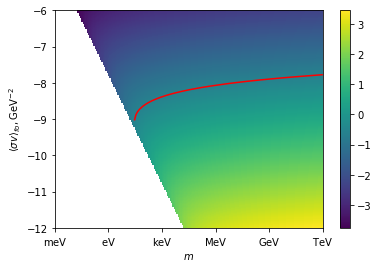

In [6]:
plot(Ocdm0)

good = []
diff = Ocdm0 - cosmo.Odm0
diff[np.isnan(diff)] = np.inf
initial_guesses = sigma[np.nanargmin(np.abs(diff), axis=0)]
for i in range(Ocdm0.shape[1]):
    ipol = interp1d(sigma, Ocdm0[:, i], kind='linear', bounds_error=False)
    res = root(lambda x: ipol(x) - cosmo.Odm0, initial_guesses[i])
    good.append(res.x[0] if res.success else np.nan)
plt.plot(np.log10(m.value), np.log10(good), 'r-')

In the plot above the blank area is the region where $A>1/\textrm{e}$, while the red line again connects parametes that give $\Omega_{\textrm{DM}, 0} = 0.26$.

TODO: explain "How does it scale with these variables?"

### Part 2: Gradual cold dark matter freeze-out


We wish to solve the Riccati equation
\begin{align}
    \frac{\textrm{d}Y}{\textrm{d}x} = \frac{s \left\langle\sigma v\right\rangle}{Hx} \left[1 + \frac{1}{3}\frac{\textrm{d}\ln{g_s}}{\textrm{d}\ln{T}}\right] \left[Y_{\textrm{eq}}^2 - Y^2\right]
    & = \left(M_p \left\langle\sigma v\right\rangle m\right) \frac{s}{m^3} x \left[\left(\frac{n_{\textrm{eq}}}{m^3} \frac{m^3}{s}\right)^2 - Y^2\right] \left[1 + \frac{1}{3}\frac{\textrm{d}\ln{g_s}}{\textrm{d}\ln{T}}\right]
    \\ & \textrm{with} \qquad \frac{s}{m^3} = \frac{2\pi^2}{45} \frac{g_s}{x^3}
    \qquad \textrm{and} \qquad \frac{n_{\textrm{eq}}}{m^3} = \frac{g}{\left(2\pi\right)^{3/2}} \frac{\textrm{e}^{-x}}{x^{3/2}}
\end{align}
subject to the initial condition $Y(x=1) = Y_{\textrm{eq}}(x=1)$. Instead, however, for greatly improved numerical performance, we will solve for $\textrm{d}\ln{Y} / \textrm{d}\ln{x}$ by introducing an additional factor $x/Y$ to the RHS.

In [18]:
def neq_overm3(x, g=1):
    return (g / (2 * np.pi * x)**(3/2)) * np.exp(-x)
def s_overm3(x, gs):
    return (2*np.pi**2/45) * gs / x**3
def Yeq(x, gs, g=1):
    return neq_overm3(x, g) / s_overm3(x, gs)

T_data, gsm_data = np.loadtxt('week_1_g.csv', delimiter=',', unpack=True)
gsm = interp1d(T_data*units.GeV, gsm_data, fill_value='extrapolate')

Tmid_data = (T_data[:-1]+T_data[1:])/2
lngsmderiv_data = np.diff(np.log(gsm_data)) / np.diff(np.log(T_data))
lngsmderiv = interp1d(Tmid_data*units.GeV, lngsmderiv_data, fill_value='extrapolate')

def Riccati(x, y, m, A, g=1):
    s = s_overm3(x, gsm(m/x))
    return A * s * x * ((neq_overm3(x, g)/s)**2 - y**2) * (1 + lngsmderiv(m/x) / 3)

In [19]:
m = 100*units.GeV

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


(-20, 5)

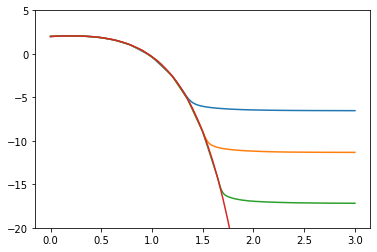

In [20]:
log10xmax = 3
y0 = Yeq(1, gsm(m))
for sexp in (-26, -21, -15):
    sigma = 2*10**sexp * (units.cm**3/units.s)/C.c
    sigma = (sigma/(C.hbar*C.c)**2).to(units.GeV**(-2))
    sol = solve_ivp(lambda logx, logy:
                        Riccati(np.exp(logx), np.exp(logy),
                                m, Mp*m*sigma)
                        * np.exp(logx-logy),
                    (0, log10xmax*np.log(10)), [np.log(y0)],
                    method='BDF')
    plt.plot(sol.t/np.log(10), 2 + sol.y[0]/np.log(10)-np.log10(y0))
plt.plot(np.linspace(0, 5, 101),
         2 + np.log10(Yeq(np.logspace(0, 5, 101),
                          gsm(m / np.logspace(0, 5, 101)))
                      / y0))
plt.ylim(-20, 5)

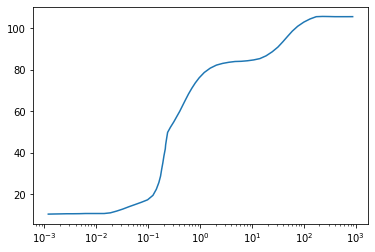

In [16]:
plt.semilogx(T_data, gsm_data)

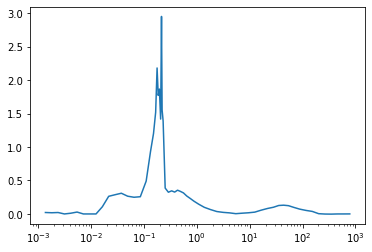

In [17]:
plt.semilogx(Tmid_data, lngsmderiv_data)